## Car price prediction

In this project we are going to build a model to predict car prices. Instead of using scikit-learn, we are going to build a linear regressor from scratch using NumPy. 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline 

First, we are going to read the .csv file with the data.

In [2]:
df = pd.read_csv('data/data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Data pre-processing

The name of the columns will be set to lower cases and the spaces will be removed. The same will be applied to the columns containing strings.

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index) 

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_') 

In [4]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [5]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Exploratory Data Analysis

Our target, the sugested car prices, are contained in the msrp (manufacturer's suggested retail price) column.

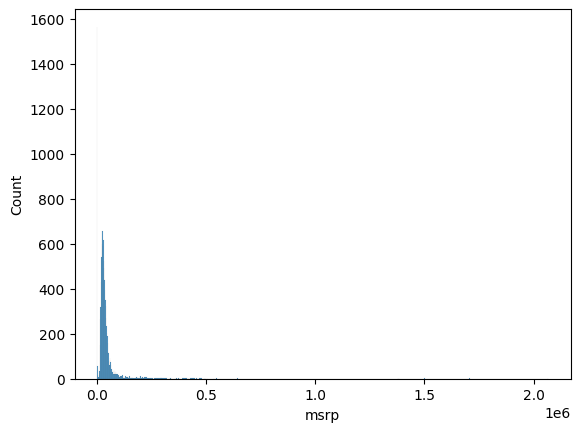

In [6]:
sns.histplot(df.msrp, kde=False);

The distribution has a long tail. Let's zoom in the part where most of the values are concentrated.

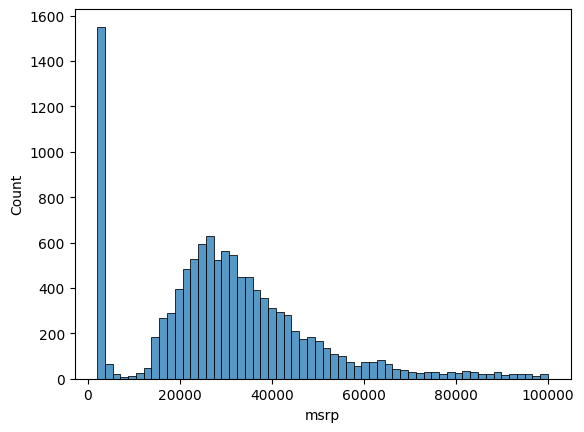

In [7]:
sns.histplot(df.msrp[df.msrp < 100000], kde=False);

This distribution can confuse the model, so it is better to make a log transformation in it.

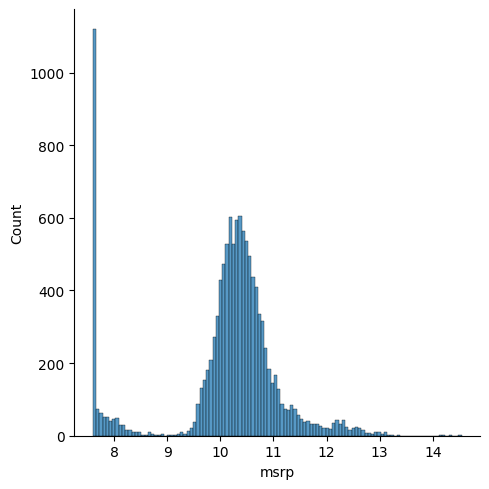

In [8]:
log_price = np.log1p(df.msrp)

sns.displot(log_price, kde=False)

Let's create a train, validation and test data. 

In [9]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(2) 
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

Now we have to recreate the log-transformed target column for the 3 datasets:

In [10]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [11]:
df_train.drop(['msrp'], axis=1, inplace=True)
df_val.drop(['msrp'], axis=1, inplace=True)
df_test.drop(['msrp'], axis=1, inplace=True)

Now, let's create a function that can implement the linear regression using NumPy. It will be able to find the weights following the normal equation:

$w = (X^TX)^{-1}X^Ty$

In [12]:
def linear_regression(X:np.array, y:np.array)->tuple:
    """Performs linear regression algorithm. 

    Args:
        X (np.array): features.
        y (np.array): results.

    Returns:
        tuple: A tuple containing the bias w_0 and the weights w_n.
    """

    # adding the dummy column for the bias term w0
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T@X
    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv@X.T@y
    
    return w[0], w[1:]

### Baseline model
Now that we have a function that implements our machine learning algorithm, we are going to train a 
baseline model in order to see how it performs. Let's first use some of the numeric features.

In [13]:
df_train.select_dtypes(include=np.number).columns.to_list()

['year',
 'engine_hp',
 'engine_cylinders',
 'number_of_doors',
 'highway_mpg',
 'city_mpg',
 'popularity']

First we choose the following values:

In [14]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

Now, we have to check for missing values. We are going to input zeros whenever missing values are found

In [15]:
df_num = df_train[base]

df_num.isna().sum()

engine_hp           40
engine_cylinders    14
highway_mpg          0
city_mpg             0
popularity           0
dtype: int64

In [16]:
df_num = df_num.fillna(0)

After dealing with the missing values, we transform the DataFrame to a NumPy array and pass it to the linear_regression function. 

In [17]:
X_train = df_num.values

w_0, w = linear_regression(X_train, y_train)

y_pred = w_0 + X_train@w

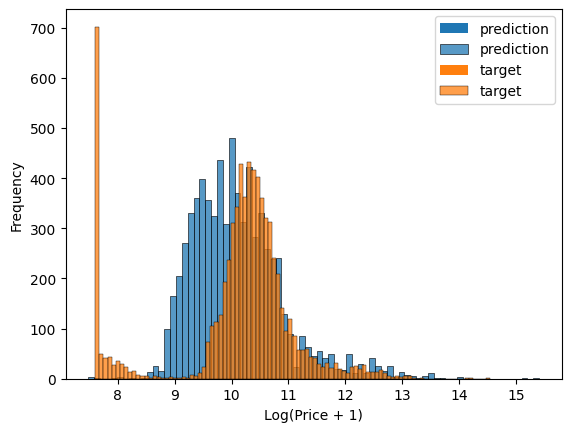

In [18]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see that the predicitions are not so good. We can create a function that calculates the root-mean-squared error (RMSE) in order to better evaluate the performance of our model.

In [19]:
def rmse(y_true:np.array, y_pred:np.array)->float:
    """Calculates the rmse for two arrays.

    Args:
        y_true (np.array): true values
        y_pred (np.array): predicted values

    Returns:
        float: RMSE value.
    """

    error = y_true - y_pred
    mse = (error ** 2).mean()

    return np.sqrt(mse)

In [20]:
rmse(y_train, y_pred)

0.7554192603920133

In [21]:
X_val = df_val[base].fillna(0).values

y_pred_val = w_0 + X_val@w

rmse(y_val, y_pred_val)

0.7616530991301607

Seems that the model have a performance in the validation set very similar to the one in the training set. But can we improve the RMSE?

### Feature Engineering

We can try to create new features and see if they improve our results. Let's begin by creating an age feature, that calculates the age of the car, considering that this dataset was created in 2017.

Also, we are going to create a function that implements the steps of preparing the X array from a DataFrame (including the creation of new features), as these steps will be repeated many times.

In [22]:
def prepare_X(df:pd.DataFrame)->np.array:
    """Prepares the X-array to be inputed in the linear regression function.

    Args:
        df (pd.DataFrame): DataFrame containing the features.

    Returns:
        np.array: DataFrame in array form.
    """
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)

    X = df_num.values

    return X

In [23]:
X_train = prepare_X(df_train) # Create the train set
X_val = prepare_X(df_val) # Create the validation set

w_0, w = linear_regression(X_train, y_train) # fit the model to the data

y_pred = w_0 + X_train@w
y_pred_val = w_0 + X_val@w

print("Train RMSE:", rmse(y_train, y_pred))
print("Validation RMSE:", rmse(y_val, y_pred_val))

Train RMSE: 0.5175055465840046
Validation RMSE: 0.5172055461058338


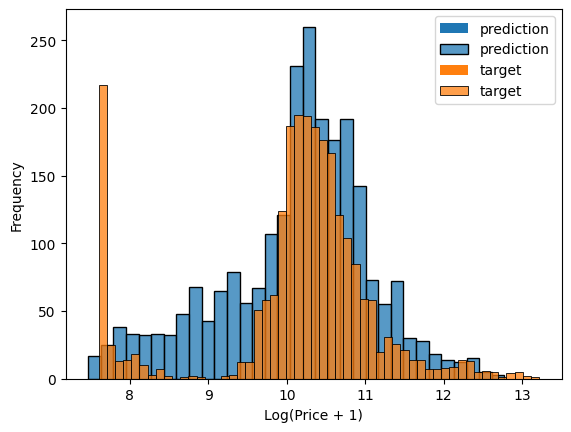

In [24]:
sns.histplot(y_pred_val, label='prediction')
sns.histplot(y_val, label='target')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The RMSE score has improved, and the prediction's distribution is closer to the target's distribution. Actually, the price of cars are commonly related to the their age, so it is a good idea to include this feature in our model.

Now, we will begin including the categorical values, and we will have to one-hot encoding all of them.

We begin by including the 'make' feature, choosing only the most common car manufacturers:

In [25]:
df['make'].value_counts().head()

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

We also include the last numerical value: number of doors, which in fact must be treated as a categorical value.

In [26]:
def prepare_X(df):

    df = df.copy()
    features = base.copy()

    # Age feature engineering
    df['age'] = 2017 - df.year
    features.append('age')

    # One-hot encoding num_doors
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    # One-hot encoding make feature
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

Now let's check if these new features add any improvement to the model.

In [27]:
X_train = prepare_X(df_train) # Create the train set
X_val = prepare_X(df_val) # Create the validation set

w_0, w = linear_regression(X_train, y_train) # fit the model to the data

y_pred = w_0 + X_train@w
y_pred_val = w_0 + X_val@w

print("Train RMSE:", rmse(y_train, y_pred))
print("Validation RMSE:", rmse(y_val, y_pred_val))

Train RMSE: 0.5058876515487503
Validation RMSE: 0.50760388495572


We've got a little improvement. Let's include the other categorical features.

In [28]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    # Age feature engineering
    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)',
    'premium_unleaded_(recommended)',
    'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive',
    'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury',
    'luxury,performance', 'hatchback']: #D
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible',
    '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In [29]:
X_train = prepare_X(df_train) # Create the train set
X_val = prepare_X(df_val) # Create the validation set

w_0, w = linear_regression(X_train, y_train) # fit the model to the data

y_pred = w_0 + X_train@w
y_pred_val = w_0 + X_val@w

print("Train RMSE:", rmse(y_train, y_pred))
print("Validation RMSE:", rmse(y_val, y_pred_val))

Train RMSE: 158.3309737528029
Validation RMSE: 58.185419582298024


The inclusion of all these features deteriorated the performance of our model, due to numerical instability. We have to apply regularization to our algorithm. 

In [30]:
def linear_regression_reg(X:np.array, y:np.array, reg:float=0.0)->tuple:
    """Performs linear regression algorithm. 

    Args:
        X (np.array): features.
        y (np.array): results.
        reg (float, optional): Regularization parameter. Defaults to 0.0.

    Returns:
        tuple: A tuple containing the bias w_0 and the weights w_n.
    """

    # adding the dummy column for the bias term w0
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T@X
    XTX = XTX - np.eye(XTX.shape[0])*reg
    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv@X.T@y
    
    return w[0], w[1:]

After including regularization, we need to check if it will really improve our results.

In [31]:
X_train = prepare_X(df_train) # Create the train set
X_val = prepare_X(df_val) # Create the validation set

w_0, w = linear_regression_reg(X_train, y_train, reg=0.001) # fit the model to the data

y_pred = w_0 + X_train@w
y_pred_val = w_0 + X_val@w

print("Train RMSE:", rmse(y_train, y_pred))
print("Validation RMSE:", rmse(y_val, y_pred_val))

Train RMSE: 0.4643121347790591
Validation RMSE: 0.4602239412575867


The regularization greatly improved our results. Let's try other values of regularization and see with we can get an even better improvement. 

In [32]:
X_train = prepare_X(df_train) # Create the train set
X_val = prepare_X(df_val) # Create the validation set

print("Validation RMSE:")
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = linear_regression_reg(X_train, y_train, reg=r) # fit the model to the data

    y_pred_val = w_0 + X_val@w
    print("Alpha = {}: {}".format(r, rmse(y_val, y_pred_val)))

Validation RMSE:
Alpha = 1e-06: 0.46022470229244056
Alpha = 0.0001: 0.46022521131989985
Alpha = 0.001: 0.4602239412575867
Alpha = 0.01: 0.46021128842297715
Alpha = 0.1: 0.46008879638116285
Alpha = 1: 0.46141788548318396
Alpha = 5: 0.5681376077638635
Alpha = 10: 0.5615139138599922


The best value is alpha = 0.1.

### Testing the Model
Finally, we can test the model in the holdout test set to how how it is going to perform after deployment.

In [33]:
X_val = prepare_X(df_val) # Create the validation set
X_test = prepare_X(df_test) # Create the train set

y_pred_val = w_0 + X_val@w
y_pred_test = w_0 + X_test@w

print("Validation RMSE:", rmse(y_val, y_pred_val))
print("Test RMSE:", rmse(y_test, y_pred_test))

Validation RMSE: 0.5615139138599922
Test RMSE: 0.5505408634172336


As these numbers are very close, we can conclude that the model can generalize well to unseen data.